#getting ready

In [2]:
#!python3 --version

In [3]:
#!pip uninstall -y tensorflow keras keras-nightly keras-preprocessing keras-core numpy pandas
#!pip install tensorflow==2.15 numpy==1.25.2 pandas==1.5.3


In [4]:
#from google.colab import drive
import pandas as pd
import numpy as np
import librosa
import librosa.display
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Concatenate, GRU, TimeDistributed
import concurrent.futures
import time
from tensorflow.keras.metrics import AUC
import h5py
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d


#code

##working with the data

In [5]:
#drive.mount('/content/drive', force_remount=True)

In [6]:
meta_data = pd.read_csv('audio_metadata - filtered_copy.csv', sep=',')
loops_data = pd.read_csv('audio_metadata - loops.csv', sep=',')

In [7]:
meta_data.drop(columns=['group', 'category', 'sub_category'], inplace=True)
loops_data.drop(columns=['group', 'category', 'sub_category'], inplace=True)

In [8]:
loops_data

,id,file_path,file_name,Reverse,Forward,One_Shot,Loop,Drum,Percussion,Effect,...,Vibraslap,Timpani,Vocal FX,China,Cowbell,Bell,Orchestra,Metalic Tap,One_Shot_Intent,Loop_Intent
0,-1,loops/Clap/Clap_0.wav,Clap_0.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,-2,loops/Clap/Clap_1.wav,Clap_1.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,-3,loops/Clap/Clap_2.wav,Clap_2.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,-4,loops/Clap/Clap_3.wav,Clap_3.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,-5,loops/Clap/Clap_4.wav,Clap_4.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,-1142,loops/Hi Hat/Closed/Closed_Hi Hat_168.wav,Closed_Hi Hat_168.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1142,-1143,loops/Hi Hat/Closed/Closed_Hi Hat_169.wav,Closed_Hi Hat_169.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1143,-1144,loops/Hi Hat/Closed/Closed_Hi Hat_170.wav,Closed_Hi Hat_170.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1144,-1145,loops/Hi Hat/Closed/Closed_Hi Hat_171.wav,Closed_Hi Hat_171.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
assert meta_data.drop(columns=['Loop_id'], inplace=False).columns.equals(loops_data.columns)

In [10]:
col_names = meta_data.columns
print(col_names)

cols_to_keep = ['id', 'Reverse', 'Forward', 'Drum' , 'Percussion', 'Kick', 'Hi Hat', 'Clap']

Index(['id', 'file_path', 'file_name', 'Reverse', 'Forward', 'One_Shot',
       'Loop', 'Drum', 'Percussion', 'Effect', 'Vocal', 'Instrument', 'Kick',
       '808', 'Clap', 'Ride', 'Hi Hat', 'Tom', 'Snare', 'Impact', 'Noise',
       'Hit', 'Sweep', 'Misc', 'Rim Shot', 'Clave', 'Snap', 'Crash',
       'Triangle', 'Congo', 'Shaker', 'Tambourine', 'Ambient', 'Stab', 'Other',
       'Chord', 'Glitch', 'Vibraslap', 'Timpani', 'Vocal FX', 'China',
       'Cowbell', 'Bell', 'Orchestra', 'Metalic Tap', 'One_Shot_Intent',
       'Loop_id', 'Loop_Intent'],
      dtype='object')


In [11]:
meta_data_non_looped = meta_data.dropna(subset=['Loop_id'])
md_non_looped = meta_data.drop(meta_data_non_looped.index)

#meta_data_one_shots = meta_data[meta_data['One_Shot_Intent'] == 1].copy()
#meta_data_loops = meta_data[(meta_data['One_Shot'] == 0)].copy()
md = pd.concat([md_non_looped, loops_data], ignore_index=True)
df_id = np.array(md_non_looped['id'].astype(int)).flatten()
looped_id = np.array(loops_data['id'].astype(int)).flatten()
print(len(md))
print(len(loops_data))

wavs = []
srs = []

def load_sample(f, sample_id):
    group = f["audio_data"][str(sample_id)]
    waveform = np.array(group["waveform"])
    sample_rate = np.array(group["sample_rate"])
    return waveform, sample_rate

with h5py.File('filtered_audio_data.h5', "r") as f:
    for i in df_id:
        waveform, sr = load_sample(f, i)  # load sample with id=42
        wavs.append(waveform)
        srs.append(sr)

wavs_loops = []
srs_loops = []

def load_sample(f, sample_id):
    group = f["audio_data"][str(sample_id)]
    waveform = np.array(group["waveform"])
    sample_rate = np.array(group["sample_rate"])
    return waveform, sample_rate

with h5py.File('generated_loop_data.h5', "r") as f:
    for i in looped_id:
        waveform, sr = load_sample(f, i)  # load sample with id=42
        wavs_loops.append(waveform)
        srs_loops.append(sr)

3366
1146


In [12]:
samples = pd.DataFrame({'id': df_id, 'waveform': wavs, 'sample_rate': srs})
samples_looped = pd.DataFrame({'id': looped_id, 'waveform': wavs_loops, 'sample_rate': srs_loops})
samples = pd.concat([samples, samples_looped], ignore_index=True)
samples['beginning_time'] = samples.apply(lambda row: len(row['waveform']) / row['sample_rate'], axis=1)

In [13]:
def highpass_filter(y, sr, cutoff=10.0, order=2):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, y)

def lowpass_filter(y, sr, cutoff=150.0, order=2):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, y)

def bandpass_filter(y, sr, lowcut=10.0, highcut=150.0, order=2):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return filtfilt(b, a, y)

def preprocess_audio(y, sr, top_db=120):
    y = librosa.resample(y, orig_sr=sr, target_sr=44100)
    y = highpass_filter(y, sr)
    y_rev = y[::-1]
    y_trimmed, _ = librosa.effects.trim(y_rev, top_db=top_db)
    y_reversed_back = y_trimmed[::-1]
    return y_reversed_back

In [14]:
# completely good to go
epsilon = 1e-8  # Small value to avoid division by zero

def get_top_middle_bottom_energies(waveform, sample_rate, n_fft=2048, hop_length=256, threshold=0.45):
  stft = np.abs(librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length))
  frequencies = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
  st = stft / (stft.max() + epsilon)

  peaks = st.max(axis=0)
  peak_bin_indices = np.argmax(st, axis=0)
  centroid_by_vol = frequencies[peak_bin_indices]
  upper_band = []
  lower_band = []

  for frame_idx, peak_bin in enumerate(peak_bin_indices):
    spectrum = st[:, frame_idx]
    upper_sub_spectrum = spectrum[peak_bin+1:]
    lower_sub_spectrum = spectrum[:peak_bin]

    th = peaks[frame_idx] * threshold

    above_thresh_upper = np.where(upper_sub_spectrum > th)[0]
    above_thresh_lower = np.where(lower_sub_spectrum > th)[0]

    if len(above_thresh_upper) > 0:
      max_bin = peak_bin + 1 + above_thresh_upper[-1]
      upper_band.append(frequencies[max_bin])
    else:
      upper_band.append(frequencies[peak_bin])

    if len(above_thresh_lower) > 0:
      if above_thresh_lower[0] == 0:
        if len(above_thresh_lower) > 1:
          min_bin = above_thresh_lower[1]
        else:
          min_bin = peak_bin
      else:
        min_bin = above_thresh_lower[0]
      lower_band.append(frequencies[min_bin])
    else:
      lower_band.append(frequencies[peak_bin])

  upper_band = np.array(upper_band)
  lower_band = np.array(lower_band)

  sigma = 1.5  # Controls the width of the smoothing — adjust as needed
  upper_band = gaussian_filter1d(upper_band, sigma=sigma)
  centroid_by_vol = gaussian_filter1d(centroid_by_vol, sigma=sigma)
  lower_band = gaussian_filter1d(lower_band, sigma=sigma)

  upper_band = np.floor(upper_band).astype(np.uint16)
  centroid_by_vol = np.floor(centroid_by_vol).astype(np.uint16)
  lower_band = np.floor(lower_band).astype(np.uint16)

  return np.stack([upper_band, centroid_by_vol, lower_band], axis=0)

In [15]:
samples

,id,waveform,sample_rate,beginning_time
0,5487,"[5.164626e-05, -0.000103295286, 2.5824858e-05,...",44100,0.466122
1,5087,"[-0.0004272461, -0.0016479492, -0.007232666, -...",44100,0.251519
2,5084,"[-0.0009765625, -0.0026550293, -0.009033203, -...",44100,0.101361
3,5083,"[-0.00039672852, -0.00045776367, -0.0014953613...",44100,0.182540
4,5098,"[-0.0029296875, -0.010894775, -0.051208496, -0...",44100,0.069841
...,...,...,...,...
3361,-1142,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,5.651202
3362,-1143,"[-0.0009750593453645706, 0.0003343060379847884...",44100,21.141814
3363,-1144,"[0.007525840308517218, 0.003047514706850052, 0...",44100,7.128594
3364,-1145,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,5.997551


In [16]:
md

,id,file_path,file_name,Reverse,Forward,One_Shot,Loop,Drum,Percussion,Effect,...,Timpani,Vocal FX,China,Cowbell,Bell,Orchestra,Metalic Tap,One_Shot_Intent,Loop_id,Loop_Intent
0,5487,808 and kick/heavy kick.wav,Heavy Kick.wav,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1.0,NaN,0.0
1,5087,808 samples/808/bass (12).wav,bass (12).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1.0,NaN,0.0
2,5084,808 samples/808/bass (13).wav,bass (13).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1.0,NaN,0.0
3,5083,808 samples/808/bass (14).wav,bass (14).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1.0,NaN,0.0
4,5098,808 samples/808/bass (16).wav,bass (16).wav,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3361,-1142,loops/Hi Hat/Closed/Closed_Hi Hat_168.wav,Closed_Hi Hat_168.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0.0,NaN,1.0
3362,-1143,loops/Hi Hat/Closed/Closed_Hi Hat_169.wav,Closed_Hi Hat_169.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0.0,NaN,1.0
3363,-1144,loops/Hi Hat/Closed/Closed_Hi Hat_170.wav,Closed_Hi Hat_170.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0.0,NaN,1.0
3364,-1145,loops/Hi Hat/Closed/Closed_Hi Hat_171.wav,Closed_Hi Hat_171.wav,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0.0,NaN,1.0


In [17]:
# resample the samples
# samples['waveform'] = samples.apply(lambda row: librosa.resample(row['waveform'], orig_sr=row['sample_rate'], target_sr=44100), axis=1)
samples['waveform'] = samples.apply(lambda row: preprocess_audio(row['waveform'], row['sample_rate']), axis=1)
samples['sample_rate'] = 44100

In [18]:
"""samples['waveform_150_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate']), axis=1)
samples['waveform_500_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=500), axis=1)
samples['waveform_2k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=2000), axis=1)
samples['waveform_6k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=6000), axis=1)
samples['waveform_10k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=10000), axis=1)

samples['waveform_150_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=150), axis=1)
samples['waveform_500_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=500), axis=1)
samples['waveform_2k_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=2000), axis=1)
samples['waveform_6k_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=6000), axis=1)
samples['waveform_10k_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=10000), axis=1)"""

"samples['waveform_150_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate']), axis=1)\nsamples['waveform_500_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=500), axis=1)\nsamples['waveform_2k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=2000), axis=1)\nsamples['waveform_6k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=6000), axis=1)\nsamples['waveform_10k_lpf'] = samples.apply(lambda row: lowpass_filter(row['waveform'], row['sample_rate'], cutoff=10000), axis=1)\n\nsamples['waveform_150_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=150), axis=1)\nsamples['waveform_500_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sample_rate'], cutoff=500), axis=1)\nsamples['waveform_2k_hpf'] = samples.apply(lambda row: highpass_filter(row['waveform'], row['sa

In [19]:
samples

,id,waveform,sample_rate,beginning_time
0,5487,"[-0.006019970409507629, -0.006184377832092783,...",44100,0.466122
1,5087,"[-0.11037421530703469, -0.11149434109602765, -...",44100,0.251519
2,5084,"[-0.15586456448634184, -0.1574027766114431, -0...",44100,0.101361
3,5083,"[-0.15896714769523557, -0.15887888934624483, -...",44100,0.182540
4,5098,"[-0.3009931289487842, -0.30866833521435133, -0...",44100,0.069841
...,...,...,...,...
3361,-1142,"[-2.9898780190053037e-10, -2.9946223080331374e...",44100,5.651202
3362,-1143,"[0.01070337868842984, 0.012000894338361155, 0....",44100,21.141814
3363,-1144,"[0.008104879932935826, 0.0036258864929514132, ...",44100,7.128594
3364,-1145,"[-1.5896479251445245e-09, -1.5938114100618272e...",44100,5.997551


In [20]:
md["id"] = md["id"].astype(int)
samples["id"] = samples["id"].astype(int)

df = pd.merge(md, samples, on='id', how='left')

In [21]:
len(samples)

3366

In [22]:
df

,id,file_path,file_name,Reverse,Forward,One_Shot,Loop,Drum,Percussion,Effect,...,Cowbell,Bell,Orchestra,Metalic Tap,One_Shot_Intent,Loop_id,Loop_Intent,waveform,sample_rate,beginning_time
0,5487,808 and kick/heavy kick.wav,Heavy Kick.wav,0,1,1,0,1,0,0,...,0,0,0,0,1.0,NaN,0.0,"[-0.006019970409507629, -0.006184377832092783,...",44100,0.466122
1,5087,808 samples/808/bass (12).wav,bass (12).wav,0,1,1,0,1,0,0,...,0,0,0,0,1.0,NaN,0.0,"[-0.11037421530703469, -0.11149434109602765, -...",44100,0.251519
2,5084,808 samples/808/bass (13).wav,bass (13).wav,0,1,1,0,1,0,0,...,0,0,0,0,1.0,NaN,0.0,"[-0.15586456448634184, -0.1574027766114431, -0...",44100,0.101361
3,5083,808 samples/808/bass (14).wav,bass (14).wav,0,1,1,0,1,0,0,...,0,0,0,0,1.0,NaN,0.0,"[-0.15896714769523557, -0.15887888934624483, -...",44100,0.182540
4,5098,808 samples/808/bass (16).wav,bass (16).wav,0,1,1,0,1,0,0,...,0,0,0,0,1.0,NaN,0.0,"[-0.3009931289487842, -0.30866833521435133, -0...",44100,0.069841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3361,-1142,loops/Hi Hat/Closed/Closed_Hi Hat_168.wav,Closed_Hi Hat_168.wav,0,1,0,1,0,1,0,...,0,0,0,0,0.0,NaN,1.0,"[-2.9898780190053037e-10, -2.9946223080331374e...",44100,5.651202
3362,-1143,loops/Hi Hat/Closed/Closed_Hi Hat_169.wav,Closed_Hi Hat_169.wav,0,1,0,1,0,1,0,...,0,0,0,0,0.0,NaN,1.0,"[0.01070337868842984, 0.012000894338361155, 0....",44100,21.141814
3363,-1144,loops/Hi Hat/Closed/Closed_Hi Hat_170.wav,Closed_Hi Hat_170.wav,0,1,0,1,0,1,0,...,0,0,0,0,0.0,NaN,1.0,"[0.008104879932935826, 0.0036258864929514132, ...",44100,7.128594
3364,-1145,loops/Hi Hat/Closed/Closed_Hi Hat_171.wav,Closed_Hi Hat_171.wav,0,1,0,1,0,1,0,...,0,0,0,0,0.0,NaN,1.0,"[-1.5896479251445245e-09, -1.5938114100618272e...",44100,5.997551


In [23]:
# reverses samples that are marked as forward
new_rows = []
max_id = df['id'].max()
print(max_id)

for i, (waveform, reverse, forward, oneshot) in enumerate(zip(df['waveform'], df['Reverse'], df['Forward'], df['One_Shot'])):
    if reverse == 0 and forward == 1:
        audio = waveform[::-1]
        #id = df['id'].max() + 1
        row = df.iloc[i].copy()
        row['file_path'] = str(row['file_path']).split('.')[0] + '_rev.' + '.'.join(str(row['file_path']).split('.')[1:])
        row['file_name'] = str(row['file_name']).split('.')[0] + '_rev.' + '.'.join(str(row['file_name']).split('.')[1:])
        row['id'] += max_id
        row['waveform'] = audio
        row['Reverse'] = 1
        row['Forward'] = 0
        new_rows.append(row)

if new_rows:
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

37989


In [24]:
df["time"] = df.apply(lambda row: len(row['waveform']) / row['sample_rate'], axis=1)
df['is_long'] = df['time'] > 5

In [25]:
for i, (waveform, sr, is_long) in enumerate(zip(df['waveform'], df['sample_rate'], df['is_long'])):
    if len(waveform) <= int(sr / 2):
        pad_len = int(sr / 2) - len(waveform)
        waveform = np.pad(waveform, (0, pad_len), mode='constant')
    else:
        remainder = len(waveform) % int(sr / 2)
        remainder = int(sr / 2) - remainder
        # full_size = len(waveform) + remainder
        waveform = np.pad(waveform, (0, remainder), mode='constant')

    '''if is_long == True:
        fade_len = int(sr * 0.1
    elif is_long == False:
        fade_len = int(sr * 0.1)
        waveform = waveform[:sr]
        fade = np.linspace(1, 0, fade_len)
        waveform[-fade_len:] *= fade'''

    df.at[i, 'waveform'] = waveform

In [26]:
# df["time"] = df.apply(lambda row: len(row['waveform']) / row['sample_rate'], axis=1)

In [27]:
df

,id,file_path,file_name,Reverse,Forward,One_Shot,Loop,Drum,Percussion,Effect,...,Orchestra,Metalic Tap,One_Shot_Intent,Loop_id,Loop_Intent,waveform,sample_rate,beginning_time,time,is_long
0,5487,808 and kick/heavy kick.wav,Heavy Kick.wav,0,1,1,0,1,0,0,...,0,0,1.0,NaN,0.0,"[-0.006019970409507629, -0.006184377832092783,...",44100,0.466122,0.466122,False
1,5087,808 samples/808/bass (12).wav,bass (12).wav,0,1,1,0,1,0,0,...,0,0,1.0,NaN,0.0,"[-0.11037421530703469, -0.11149434109602765, -...",44100,0.251519,0.251519,False
2,5084,808 samples/808/bass (13).wav,bass (13).wav,0,1,1,0,1,0,0,...,0,0,1.0,NaN,0.0,"[-0.15586456448634184, -0.1574027766114431, -0...",44100,0.101361,0.101361,False
3,5083,808 samples/808/bass (14).wav,bass (14).wav,0,1,1,0,1,0,0,...,0,0,1.0,NaN,0.0,"[-0.15896714769523557, -0.15887888934624483, -...",44100,0.182540,0.182540,False
4,5098,808 samples/808/bass (16).wav,bass (16).wav,0,1,1,0,1,0,0,...,0,0,1.0,NaN,0.0,"[-0.3009931289487842, -0.30866833521435133, -0...",44100,0.069841,0.069841,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6704,36847,loops/Hi Hat/Closed/Closed_Hi Hat_168_rev.wav,Closed_Hi Hat_168_rev.wav,1,0,0,1,0,1,0,...,0,0,0.0,NaN,1.0,"[1.276374984881917e-05, -2.426283817068876e-07...",44100,5.651202,5.651202,True
6705,36846,loops/Hi Hat/Closed/Closed_Hi Hat_169_rev.wav,Closed_Hi Hat_169_rev.wav,1,0,0,1,0,1,0,...,0,0,0.0,NaN,1.0,"[-0.00015387442280273306, -0.00014844237476506...",44100,21.141814,21.141814,True
6706,36845,loops/Hi Hat/Closed/Closed_Hi Hat_170_rev.wav,Closed_Hi Hat_170_rev.wav,1,0,0,1,0,1,0,...,0,0,0.0,NaN,1.0,"[-2.9604776234636582e-05, -0.00017946830613444...",44100,7.128594,7.128594,True
6707,36844,loops/Hi Hat/Closed/Closed_Hi Hat_171_rev.wav,Closed_Hi Hat_171_rev.wav,1,0,0,1,0,1,0,...,0,0,0.0,NaN,1.0,"[-1.036149118759291e-11, -1.1502103547849135e-...",44100,5.997551,5.997551,True


In [28]:
def extract_mfcc(audio, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc

def extract_mel(audio, sr, n_mels=64):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_db

def resize_and_normalize(current_features, all_features, target_shape=(64, 64)):
    current_features = np.array(current_features)
    current_features = tf.image.resize(current_features[..., np.newaxis], target_shape)

    all_features = np.array(all_features)
    #all_features = tf.image.resize(all_features[..., np.newaxis], target_shape)

    epsilon = 1e-8  # Small value to avoid division by zero
    feature = current_features / (tf.reduce_max(all_features) + epsilon)
    return feature.numpy()  # shape: (64, 64, 1)

In [29]:
def extract_centroid(audio, sr):
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    return centroid

def extract_bandwidth(audio, sr):
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    return bandwidth

In [30]:
cut_df = df[df['is_long'] == False].copy()

In [31]:
len(cut_df)

5150

In [32]:
# test_labels = 'id,Reverse,Forward,Drum,Percussion,One_Shot,Loop'.split(',')
impt_labels = 'id,file_path,file_name,Reverse,Forward,One_Shot_Intent,Loop_Intent,Drum,Percussion,Kick,Hi Hat,Clap,waveform,sample_rate'.split(',')
impt_labels

['id',
 'file_path',
 'file_name',
 'Reverse',
 'Forward',
 'One_Shot_Intent',
 'Loop_Intent',
 'Drum',
 'Percussion',
 'Kick',
 'Hi Hat',
 'Clap',
 'waveform',
 'sample_rate']

In [33]:
cut = cut_df[impt_labels].copy()
len(cut)

5150

In [34]:
cut.head(5)

,id,file_path,file_name,Reverse,Forward,One_Shot_Intent,Loop_Intent,Drum,Percussion,Kick,Hi Hat,Clap,waveform,sample_rate
0,5487,808 and kick/heavy kick.wav,Heavy Kick.wav,0,1,1.0,0.0,1,0,1,0,0,"[-0.006019970409507629, -0.006184377832092783,...",44100
1,5087,808 samples/808/bass (12).wav,bass (12).wav,0,1,1.0,0.0,1,0,1,0,0,"[-0.11037421530703469, -0.11149434109602765, -...",44100
2,5084,808 samples/808/bass (13).wav,bass (13).wav,0,1,1.0,0.0,1,0,1,0,0,"[-0.15586456448634184, -0.1574027766114431, -0...",44100
3,5083,808 samples/808/bass (14).wav,bass (14).wav,0,1,1.0,0.0,1,0,1,0,0,"[-0.15896714769523557, -0.15887888934624483, -...",44100
4,5098,808 samples/808/bass (16).wav,bass (16).wav,0,1,1.0,0.0,1,0,1,0,0,"[-0.3009931289487842, -0.30866833521435133, -0...",44100


In [35]:
# columns_to_check = ['Kick', '808', 'Clap', 'Hi Hat', 'Snare']
#columns_to_check = ['Kick', 'Hi Hat', 'Clap']

# Filter rows where there is a 1 in any of the specified columns
#filtered_cut_df = cut_df[columns_to_check].copy()
#filtered_cut_df['id'] = cut_df['id'].astype(int)
#len(filtered_cut_df)

In [36]:
#columns_to_check += ['id']

In [37]:
#len(filtered_cut_df)

In [38]:
#filtered_cut_df = filtered_cut_df[columns_to_check].copy()
#cut_df[['waveform', 'sample_rate', 'beginning_time', 'is_long']]

In [39]:
#cut = pd.merge(cut, filtered_cut_df, on='id')
#cut = pd.merge(cut, cut_df[['id', 'waveform', 'sample_rate', 'beginning_time', 'is_long']], on='id')

In [40]:
cut

,id,file_path,file_name,Reverse,Forward,One_Shot_Intent,Loop_Intent,Drum,Percussion,Kick,Hi Hat,Clap,waveform,sample_rate
0,5487,808 and kick/heavy kick.wav,Heavy Kick.wav,0,1,1.0,0.0,1,0,1,0,0,"[-0.006019970409507629, -0.006184377832092783,...",44100
1,5087,808 samples/808/bass (12).wav,bass (12).wav,0,1,1.0,0.0,1,0,1,0,0,"[-0.11037421530703469, -0.11149434109602765, -...",44100
2,5084,808 samples/808/bass (13).wav,bass (13).wav,0,1,1.0,0.0,1,0,1,0,0,"[-0.15586456448634184, -0.1574027766114431, -0...",44100
3,5083,808 samples/808/bass (14).wav,bass (14).wav,0,1,1.0,0.0,1,0,1,0,0,"[-0.15896714769523557, -0.15887888934624483, -...",44100
4,5098,808 samples/808/bass (16).wav,bass (16).wav,0,1,1.0,0.0,1,0,1,0,0,"[-0.3009931289487842, -0.30866833521435133, -0...",44100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6699,36852,loops/Hi Hat/Closed/Closed_Hi Hat_163_rev.wav,Closed_Hi Hat_163_rev.wav,1,0,0.0,1.0,0,1,0,1,0,"[4.623688457787311e-06, 9.184309259438066e-06,...",44100
6701,36850,loops/Hi Hat/Closed/Closed_Hi Hat_165_rev.wav,Closed_Hi Hat_165_rev.wav,1,0,0.0,1.0,0,1,0,1,0,"[-2.832712350762353e-07, -3.1447632921189733e-...",44100
6702,36849,loops/Hi Hat/Closed/Closed_Hi Hat_166_rev.wav,Closed_Hi Hat_166_rev.wav,1,0,0.0,1.0,0,1,0,1,0,"[0.0002640420299600567, 0.000368340753766418, ...",44100
6703,36848,loops/Hi Hat/Closed/Closed_Hi Hat_167_rev.wav,Closed_Hi Hat_167_rev.wav,1,0,0.0,1.0,0,1,0,1,0,"[-7.808293715764585e-11, -8.683800441068409e-1...",44100


In [41]:
# took 7 minutes to run. parallelize this

mfcc_processed = []
mel_processed = []
#
bandwidth_arr_window = []
onset_str_arr_window = []
zcr_arr_window = []
centroid_arr_window = []
energies_arr_window = []
rms_arr_window = []

energies_arr = []
onset_str_arr = []
zcr_arr = []
centroid_arr = []
bandwidth_arr = []
onset_frame_len_arr = []

window_size = 0.5
hop_size = 0.25

i = 0
for audio, sr in zip(cut_df["waveform"], cut_df["sample_rate"]):
    if i % 50 == 0:
      print(i)
    i += 1
    window_samples = int(window_size * sr)
    hop_samples = int(hop_size * sr)
    mfcc_windows = []
    mel_windows = []

    #
    onset_windows = []
    zcr_windows = []
    centroid_windows = []
    bandwidth_windows = []
    energies_windows = []
    rms_windows = []

    fade_len = int(sr * 0.025)
    fade_out = np.linspace(1, 0, fade_len)
    fade_in = np.linspace(0, 1, fade_len)

    # Extract features
    for start in range(0, len(audio) - window_samples + 1, hop_samples):
        window_audio = audio[start:start + window_samples].copy()

        # fade out
        window_audio[-fade_len:] *= fade_out

        #fade in if not at the beginning
        if start != 0:
          window_audio[:fade_len] *= fade_in

        mfcc = extract_mfcc(window_audio, sr)
        mel = extract_mel(window_audio, sr)

        #
        onset_str_w = librosa.onset.onset_strength(y=window_audio, sr=sr)
        zcr_w = librosa.feature.zero_crossing_rate(window_audio)
        centroid_w = extract_centroid(window_audio, sr)
        bandwidth_w = extract_bandwidth(window_audio, sr)
        energies_w = get_top_middle_bottom_energies(window_audio, sr)
        rms_w = librosa.feature.rms(y=window_audio)

        # Resize + normalize
        mfcc_resized = resize_and_normalize(mfcc.astype(np.float32), audio.astype(np.float32))
        mel_resized = resize_and_normalize(mel.astype(np.float32), audio.astype(np.float32))

        mfcc_windows.append(mfcc_resized)
        mel_windows.append(mel_resized)

        #
        onset_windows.append(onset_str_w)
        zcr_windows.append(zcr_w)
        centroid_windows.append(centroid_w)
        bandwidth_windows.append(bandwidth_w)
        energies_windows.append(energies_w)
        rms_windows.append(rms_w)

        del window_audio

    mfcc_windows = np.stack(mfcc_windows, axis=0)
    mel_windows = np.stack(mel_windows, axis=0)

    #
    onset_windows = np.stack(onset_windows, axis=0)
    zcr_windows = np.stack(zcr_windows, axis=0)
    centroid_windows = np.stack(centroid_windows, axis=0)
    bandwidth_windows = np.stack(bandwidth_windows, axis=0)
    energies_windows = np.stack(energies_windows, axis=0)
    rms_windows = np.stack(rms_windows, axis=0)

    onset_str = librosa.onset.onset_strength(y=audio, sr=sr, hop_length=512, lag=3, max_size=5, aggregate=np.mean)
    onset_str = gaussian_filter1d(onset_str, sigma=2)
    onset_frame_len = len(librosa.onset.onset_detect(onset_envelope=onset_str, sr=sr, hop_length=512, backtrack=False, pre_max=10, post_max=10, pre_avg=20, post_avg=20, delta=0.1, wait=50))
    zcr = librosa.feature.zero_crossing_rate(audio)
    energies = get_top_middle_bottom_energies(audio, sr)
    centroid = extract_centroid(audio, sr)
    bandwidth = extract_bandwidth(audio, sr)

    # Append to lists
    mfcc_processed.append(mfcc_windows)
    mel_processed.append(mel_windows)

    #
    centroid_arr_window.append(centroid_windows)
    bandwidth_arr_window.append(bandwidth_windows)
    onset_str_arr_window.append(onset_windows)
    zcr_arr_window.append(zcr_windows)
    energies_arr_window.append(energies_windows)
    rms_arr_window.append(rms_windows)

    onset_str_arr.append(onset_str)
    zcr_arr.append(zcr)
    centroid_arr.append(centroid)
    bandwidth_arr.append(bandwidth)
    energies_arr.append(energies)
    onset_frame_len_arr.append(onset_frame_len)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100


In [42]:
# Store back in DataFrame
cut['mfcc_resized'] = mfcc_processed
cut['mel_resized'] = mel_processed

cut['centroid_window'] = centroid_arr_window
cut['bandwidth_window'] = bandwidth_arr_window
cut['onset_strength_window'] = onset_str_arr_window
cut['zcr_window'] = zcr_arr_window
cut['energies_window'] = energies_arr_window
cut['rms_window'] = rms_arr_window

cut['energies'] = energies_arr
#cut_df['centroid'] = cut_df['energies'].apply(lambda x: x[1])
cut['centroid'] = centroid_arr
cut['bandwidth'] = bandwidth_arr
cut['onset_strength'] = onset_str_arr
cut['onset_frame_count'] = onset_frame_len_arr
cut['zcr'] = zcr_arr

In [43]:
cut

,id,file_path,file_name,Reverse,Forward,One_Shot_Intent,Loop_Intent,Drum,Percussion,Kick,...,onset_strength_window,zcr_window,energies_window,rms_window,energies,centroid,bandwidth,onset_strength,onset_frame_count,zcr
0,5487,808 and kick/heavy kick.wav,Heavy Kick.wav,0,1,1.0,0.0,1,0,1,...,"[[0.0, 0.0, 0.0, 0.3736117193233884, 0.2005905...","[[[0.00341796875, 0.00390625, 0.0048828125, 0....","[[[205, 190, 168, 147, 128, 111, 98, 89, 83, 7...","[[[0.442579, 0.5460109, 0.5793358, 0.49942532,...","[[205, 190, 168, 147, 128, 111, 98, 89, 83, 77...","[[542.3643528596853, 396.32932287710753, 197.6...","[[1444.968403633845, 1129.180499359296, 730.10...","[0.0010151950776194005, 0.0025362900249947893,...",1,"[[0.00341796875, 0.00390625, 0.0048828125, 0.0..."
1,5087,808 samples/808/bass (12).wav,bass (12).wav,0,1,1.0,0.0,1,0,1,...,"[[0.0, 0.0, 0.0, 0.15192075831412596, 0.021225...","[[[0.001953125, 0.00244140625, 0.0029296875, 0...","[[[144, 126, 103, 85, 74, 68, 65, 64, 64, 64, ...","[[[0.39077088, 0.46366647, 0.50752056, 0.45487...","[[144, 126, 103, 85, 74, 68, 65, 64, 64, 64, 6...","[[761.5967002901664, 407.4033433287085, 81.908...","[[2626.1189637019966, 1855.8558245952859, 464....","[0.0006681118192749854, 0.0016691622922186283,...",1,"[[0.001953125, 0.00244140625, 0.0029296875, 0...."
2,5084,808 samples/808/bass (13).wav,bass (13).wav,0,1,1.0,0.0,1,0,1,...,"[[0.0, 0.0, 0.0, 0.12817845798310204, 0.0, 0.0...","[[[0.001953125, 0.00244140625, 0.0029296875, 0...","[[[175, 152, 120, 93, 76, 68, 65, 64, 64, 64, ...","[[[0.407837, 0.4280139, 0.43113485, 0.28098422...","[[175, 152, 120, 93, 76, 68, 65, 64, 64, 64, 6...","[[832.5431131074325, 484.90858243151206, 92.74...","[[2751.432364372728, 2051.6667587882353, 579.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[[0.001953125, 0.00244140625, 0.0029296875, 0...."
3,5083,808 samples/808/bass (14).wav,bass (14).wav,0,1,1.0,0.0,1,0,1,...,"[[0.0, 0.0, 0.0, 0.14344933026157242, 0.018186...","[[[0.001953125, 0.00244140625, 0.0029296875, 0...","[[[168, 146, 115, 90, 75, 68, 65, 64, 64, 64, ...","[[[0.39509693, 0.46877167, 0.51090336, 0.44920...","[[168, 146, 115, 90, 75, 68, 65, 64, 64, 64, 6...","[[961.5517561710174, 538.3788669800573, 84.422...","[[2918.6824582594227, 2149.2892281319164, 493....","[0.0006719467081503881, 0.0016787431014798943,...",1,"[[0.001953125, 0.00244140625, 0.0029296875, 0...."
4,5098,808 samples/808/bass (16).wav,bass (16).wav,0,1,1.0,0.0,1,0,1,...,"[[0.0, 0.0, 0.0, 0.11103500731024052, 0.0, 0.0...","[[[0.001953125, 0.00244140625, 0.0029296875, 0...","[[[192, 166, 128, 96, 77, 68, 65, 64, 64, 65, ...","[[[0.41011226, 0.42966256, 0.43254814, 0.25367...","[[192, 166, 128, 96, 77, 68, 65, 64, 64, 65, 6...","[[1193.134027679289, 744.5600372675146, 101.74...","[[3310.3551859634085, 2615.8030223596998, 665....","[4.646267790964512e-05, 0.0003176318668754545,...",1,"[[0.001953125, 0.00244140625, 0.0029296875, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6699,36852,loops/Hi Hat/Closed/Closed_Hi Hat_163_rev.wav,Closed_Hi Hat_163_rev.wav,1,0,0.0,1.0,0,1,0,...,"[[0.0, 0.0, 0.0, 10.031641911435594, 7.4932913...","[[[0.2490234375, 0.38037109375, 0.51806640625,...","[[[15885, 15790, 15649, 15499, 15408, 15450, 1...","[[[0.0013826442, 0.0035155828, 0.0056270203, 0...","[[15885, 15790, 15649, 15499, 15408, 15450, 15...","[[11712.634733205698, 11751.125840775057, 1190...","[[4444.9442714685665, 4341.896154795978, 4391....","[0.21902130620095275, 0.5705181814682181, 1.41...",4,"[[0.2490234375, 0.38037109375, 0.51806640625, ..."
6701,36850,loops/Hi Hat/Closed/Closed_Hi Hat_165_rev.wav,Closed_Hi Hat_165_rev.wav,1,0,0.0,1.0,0,1,0,...,"[[0.0, 0.0, 0.0, 6.391862233057632, 9.13291823...","[[[0.11328125, 0.18505859375, 0.25927734375, 0...","[[[7949, 7902, 7692, 7455, 7388, 7474, 7665, 8...","[[[0.0038580028, 0.016254377, 0.039536018, 0.0...","[[7949, 7902, 7692, 7455, 7388, 7474, 7665, 80...","[[5836.3209392584085, 6948.405558898591

In [44]:
epsilon = 1e-8  # Small value to avoid division by zero

# remove centroid, bandwidths, onsets.
# maybe keep zcr??

#cut_df['centroid_mean'] = cut_df['energies'].apply(lambda x: np.mean(x[1]))
cut['centroid_mean'] = cut['energies'].apply(lambda x: np.mean(x))
#cut_df['bandwidth_mean'] = cut_df['energies'].apply(lambda x: np.mean(x[0] - x[2]))
cut['bandwidth_mean'] = cut['bandwidth'].apply(lambda x: np.mean(x))
cut['bandwidth_low_10'] = cut['energies'].apply(lambda x: np.percentile(x[2], 10))
#cut_df['bandwidth_low_10'] = cut_df['bandwidth'].apply(lambda x: np.percentile(x, 10))
#cut_df['bandwidth_low'] = cut_df['energies'].apply(lambda x: np.min(x[2]))
cut['bandwidth_low'] = cut['energies'].apply(lambda x: np.min(x[2]))
cut['bandwidth_high_90'] = cut['energies'].apply(lambda x: np.percentile(x[0], 90))
#cut_df['bandwidth_high_90'] = cut_df['bandwidth'].apply(lambda x: np.percentile(x, 90))
# cut_df['bandwidth_high'] = cut_df['bandwidth'].apply(lambda x: np.max(x[0]))
cut['bandwidth_high'] = cut['energies'].apply(lambda x: np.max(x[0]))
cut['bandwidth_range'] = cut['bandwidth_high_90'] - cut['bandwidth_low_10']
cut['onset_strength_max'] = cut['onset_strength'].apply(lambda x: np.max(x))
cut['onset_strength_mean'] = cut['onset_strength'].apply(lambda x: np.mean(x))
cut['onset_strength_ratio'] = cut['onset_strength_max'] / (cut['onset_strength_mean'] + epsilon)
cut['zcr_mean'] = cut['zcr'].apply(lambda x: np.mean(x))

In [54]:
# predictor_labels = 'Reverse,Forward,Drum,Percussion,Effect,Vocal,Instrument,Kick,808,Clap,Ride,Hi Hat,Tom,Snare,Impact,Noise,Hit,Sweep,Misc,Rim Shot,Clave,Crash,Ambient,Stab,Other,Chord,Glitch,Shaker,Snap,Timpani,Congo,Vocal FX,Triangle,China,Cowbell,Tambourine,Bell,Metalic Tap,Vibraslap'.split(',')
predictor_labels = 'Reverse,Forward,One_Shot_Intent,Loop_Intent,Drum,Percussion,Kick,Clap,Hi Hat'.split(',')
# features_labels = ['centroid_mean', 'bandwidth_mean', 'centroid', 'bandwidth']
features_labels = ['centroid_mean', 'bandwidth_mean', 'bandwidth_low', 'bandwidth_low_10', 'bandwidth_high', 'bandwidth_high_90', 'bandwidth_range', 'onset_strength_mean', 'onset_strength_max', 'zcr_mean', 'onset_strength_ratio', 'onset_frame_count']
gru_labels = ['centroid', 'bandwidth', 'zcr', 'onset_strength']

In [46]:
X_images = []
X_energies = []

for i in range(0, len(cut['id'])):
  images = np.concatenate([cut.iloc[i]['mfcc_resized'], cut.iloc[i]['mel_resized']], axis=3)
  energies = cut.iloc[i]['energies_window']
  X_energies.append(energies)
  X_images.append(images)

X_images = np.asarray(X_images, dtype=object)
X_energies = np.asarray(X_energies, dtype=object)

y = cut.copy()

In [47]:
print(cut.iloc[5]['centroid_window'].shape)
print(cut.iloc[5]['bandwidth_window'].shape)
print(cut.iloc[5]['zcr_window'].shape)
print(cut.iloc[5]['onset_strength_window'].shape)
print(cut.iloc[5]['rms_window'].shape)
print(cut.iloc[5]['energies_window'].shape)

(3, 1, 44)
(3, 1, 44)
(3, 1, 44)
(3, 44)
(3, 1, 44)
(3, 3, 87)


In [48]:
# arr = np.stack((cut_df['centroid_window'], cut_df['bandwidth_window'], cut_df['zcr_window'], cut_df['onset_strength_window']), axis=1)

In [49]:
'''cut[predictor_labels].head(5)

X_gru = []

def safe_squeeze(arr):
  arr = np.array(arr)
  arr = np.squeeze(arr)
  if arr.ndim == 1:
      arr = np.expand_dims(arr, axis=0)  # Ensure shape (1, feature_dim)
  return arr

for i in range(len(cut)):
  centroids = safe_squeeze(cut.iloc[i]['centroid_window'])
  bandwidths = safe_squeeze(cut.iloc[i]['bandwidth_window'])
  zcrs = safe_squeeze(cut.iloc[i]['zcr_window'])
  onsets = safe_squeeze(cut.iloc[i]['onset_strength_window'])

  centroids = centroids[:, :44]
  bandwidths = bandwidths[:, :44]
  zcrs = zcrs[:, :44]
  onsets = onsets[:, :44]

  x = np.concatenate([centroids, bandwidths, onsets, zcrs], axis=1)
  X_gru.append(x)

X_gru = np.asarray(X_gru, dtype=object)'''

"cut[predictor_labels].head(5)\n\nX_gru = []\n\ndef safe_squeeze(arr):\n  arr = np.array(arr)\n  arr = np.squeeze(arr)\n  if arr.ndim == 1:\n      arr = np.expand_dims(arr, axis=0)  # Ensure shape (1, feature_dim)\n  return arr\n\nfor i in range(len(cut)):\n  centroids = safe_squeeze(cut.iloc[i]['centroid_window'])\n  bandwidths = safe_squeeze(cut.iloc[i]['bandwidth_window'])\n  zcrs = safe_squeeze(cut.iloc[i]['zcr_window'])\n  onsets = safe_squeeze(cut.iloc[i]['onset_strength_window'])\n\n  centroids = centroids[:, :44]\n  bandwidths = bandwidths[:, :44]\n  zcrs = zcrs[:, :44]\n  onsets = onsets[:, :44]\n\n  x = np.concatenate([centroids, bandwidths, onsets, zcrs], axis=1)\n  X_gru.append(x)\n\nX_gru = np.asarray(X_gru, dtype=object)"

In [50]:
X_spectrums = []

for i in range(len(cut)):
    o = cut.iloc[i]['onset_strength_window']
    o = o[:, np.newaxis, :]
    
    specs = np.concatenate([cut.iloc[i]['centroid_window'], cut.iloc[i]['bandwidth_window'], cut.iloc[i]['zcr_window'], o, cut.iloc[i]['rms_window']], axis=1)
    X_spectrums.append(specs)

X_spectrums = np.asarray(X_spectrums, dtype='object')
#X_spectrums = tf.ragged.constant(X_spectrums, dtype=tf.float32, ragged_rank=1)

In [51]:
X_features = cut[features_labels].astype(np.float32).to_numpy()

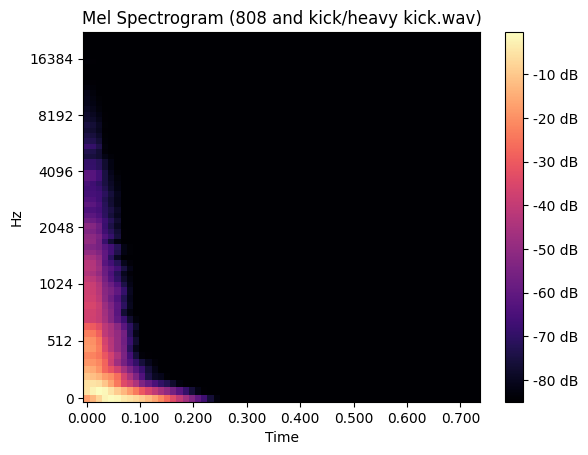

In [52]:
idx = 0
librosa.display.specshow(X_images[idx][0, :, :, 1].squeeze(), sr=df['sample_rate'][idx], x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel Spectrogram ({df['file_path'][idx]})")
plt.show()

In [53]:
X_train_images, X_test_images, X_train_features, X_test_features, X_train_spectrums, X_test_spectrums, X_train_energies, X_test_energies, y_train, y_test = train_test_split(X_images, X_features, X_spectrums, X_energies, y, test_size=0.2, random_state=42)

X_train_images = tf.ragged.constant(X_train_images, dtype=tf.float32, ragged_rank=1)
X_test_images = tf.ragged.constant(X_test_images, dtype=tf.float32, ragged_rank=1)
#X_train_gru = tf.ragged.constant(X_train_gru, dtype=tf.float32, ragged_rank=1)
#X_test_gru = tf.ragged.constant(X_test_gru, dtype=tf.float32, ragged_rank=1)
X_train_spectrums = tf.ragged.constant(X_train_spectrums, dtype=tf.float32, ragged_rank=1)
X_test_spectrums = tf.ragged.constant(X_test_spectrums, dtype=tf.float32, ragged_rank=1)
X_train_energies = tf.ragged.constant(X_train_energies, dtype=tf.float32, ragged_rank=1)
X_test_energies = tf.ragged.constant(X_test_energies, dtype=tf.float32, ragged_rank=1)

X_train_energies = X_train_energies.with_flat_values(
    tf.expand_dims(tf.cast(X_train_energies.flat_values, tf.float32), axis=-1)
)
X_test_energies = X_test_energies.with_flat_values(
    tf.expand_dims(tf.cast(X_test_energies.flat_values, tf.float32), axis=-1)
)

X_train_spectrums = X_train_spectrums.with_flat_values(
    tf.expand_dims(tf.cast(X_train_spectrums.flat_values, tf.float32), axis=-1)
)
X_test_spectrums = X_test_spectrums.with_flat_values(
    tf.expand_dims(tf.cast(X_test_spectrums.flat_values, tf.float32), axis=-1)
)

#X_train_spectrums = tf.ragged.map_flat_values(lambda x: tf.expand_dims(x, axis=-1), X_train_spectrums)
#X_test_spectrums = tf.ragged.map_flat_values(lambda x: tf.expand_dims(x, axis=-1), X_test_spectrums)


y_train_pd = y_train[predictor_labels].to_numpy()
y_test_pd = y_test[predictor_labels].to_numpy()

KeyError: "['One_Shot', 'Loop'] not in index"

In [ ]:
#y_train_pd = y_train[predictor_labels].to_numpy()
#y_test_pd = y_test[predictor_labels].to_numpy()

In [56]:
print(X_train_images.shape)
print(X_train_energies.shape)
print(X_train_spectrums.shape)
#print(len(X_test_images))

(4120, None, 64, 64, 2)
(4120, None, 3, 87, 1)
(4120, None, 5, 44, 1)


In [57]:
print(len(y_train))
print(len(y_test))

#1585
#397

4120
1030


In [58]:
y_train_pd[:5]

array([[1., 0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 1., 1., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 0., 1.],
       [0., 1., 1., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [59]:
print(type(y_train))
print(np.isnan(y_test[predictor_labels]).any())

<class 'pandas.core.frame.DataFrame'>
Reverse            False
Forward            False
One_Shot_Intent    False
Loop_Intent        False
Drum               False
Percussion         False
Kick               False
Clap               False
Hi Hat             False
dtype: bool


In [60]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [61]:
print(X_train_energies[0][0].shape[0])

3


##creating model

##predict

In [ ]:
print(X_train_energies[0][0].shape[0])

3


In [ ]:
print(X_train_spectrums[0][0].shape[0],X_train_spectrums[0][0].shape[1],X_train_spectrums[0][0].shape[2])
print(X_train_spectrums[0].shape) 

5 44 1
(5, 5, 44, 1)


In [62]:
dropout_val_1 = 0.35
dropout_val_2 = 0.5

# Define CNN model
tf.keras.backend.clear_session()

images_cnn_branch = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(X_train_images[0][0].shape[0],X_train_images[0][0].shape[1],X_train_images[0][0].shape[2])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    #Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    #BatchNormalization(),
    #MaxPooling2D((2, 2)),
    #Dropout(0.25),

    tf.keras.layers.Flatten()
])

energies_cnn_branch = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(X_train_energies[0][0].shape[0], X_train_energies[0][0].shape[1], X_train_energies[0][0].shape[2])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((1, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((1, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Flatten()
])

# branch for features (1 data point per feature)
features_branch = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(len(features_labels),)),
    tf.keras.layers.Dropout(dropout_val_1)
])

# branch for gru (array data)
'''gru_branch = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(None, 176))),
    tf.keras.layers.Dropout(dropout_val_1)
])'''


spectrums_cnn_branch = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(X_train_spectrums[0][0].shape[0],X_train_spectrums[0][0].shape[1],X_train_spectrums[0][0].shape[2])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((1, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((1, 2)),
    tf.keras.layers.Dropout(dropout_val_1),

    tf.keras.layers.Flatten()
])

# Inputs
input_images_cnn = tf.keras.layers.Input(shape=(None, X_train_images[0][0].shape[0],X_train_images[0][0].shape[1],X_train_images[0][0].shape[2]), ragged=True, dtype=tf.float32, name="images_input" )
input_features = tf.keras.layers.Input(shape=(len(features_labels),), ragged=True, dtype=tf.float32, name='features_input' )
#input_gru = tf.keras.Input(shape=(None, 176), ragged=True, name='gru_input')
input_spectrums_cnn = tf.keras.Input(shape=(None, X_train_spectrums[0][0].shape[0],X_train_spectrums[0][0].shape[1],X_train_spectrums[0][0].shape[2]), ragged=True, dtype=tf.float32, name='spectrums_input')
input_energies_cnn = tf.keras.layers.Input(shape=(None, X_train_energies[0][0].shape[0], X_train_energies[0][0].shape[1], X_train_energies[0][0].shape[2]), ragged=True, name='energies_input')

# images CNN + GRU path
images_time_dist = tf.keras.layers.TimeDistributed(images_cnn_branch, name='images_cnn_time_dist')(input_images_cnn)
images_cnn_gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', return_sequences=True, recurrent_activation='sigmoid', recurrent_dropout=dropout_val_1))(images_time_dist)
images_cnn_gru_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=dropout_val_1))(images_cnn_gru_1)
# add dropout layer(s)

# energies CNN + GRU path
energies_time_dist = tf.keras.layers.TimeDistributed(energies_cnn_branch, name='energies_cnn_time_dist')(input_energies_cnn)
energies_cnn_gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=dropout_val_1))(energies_time_dist)
energies_cnn_gru_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=dropout_val_1))(energies_cnn_gru_1)
# add dropout layer(s)

# feature path
features_out = features_branch(input_features)

# gru path
#gru_out = gru_branch(input_gru)

# spectrums CNN + GRU path
spectrums_time_dist = tf.keras.layers.TimeDistributed(spectrums_cnn_branch, name='spectrums_cnn_time_dist')(input_spectrums_cnn)
spectrums_cnn_gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, recurrent_dropout=dropout_val_1))(spectrums_time_dist)
spectrums_cnn_gru_out = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=dropout_val_1))(spectrums_cnn_gru_1)

# Merging branches
merged_temporal_1 = tf.keras.layers.Concatenate()([images_cnn_gru_out, spectrums_cnn_gru_out])
merged_temporal_2 = tf.keras.layers.Concatenate()([merged_temporal_1, energies_cnn_gru_out])
merged = tf.keras.layers.Concatenate()([merged_temporal_2, features_out])

# Final output
#x = Dense(256, activation=tf.keras.layers.LeakyReLU(negative_slope=0.01))(merged)
#x = Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(merged)
x = tf.keras.layers.Dropout(0.5)(x)
final_output = tf.keras.layers.Dense(y_train[predictor_labels].shape[1], activation="sigmoid")(x)  # Output layer'''

model = tf.keras.Model(inputs=[input_images_cnn, input_features, input_spectrums_cnn, input_energies_cnn], outputs=final_output)

# Compile model
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00064)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[AUC(name='auc', multi_label=True), 'binary_accuracy'])

In [63]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 images_input (InputLayer)   [(None, None, 64, 64, 2)]    0         []                            
                                                                                                  
 spectrums_input (InputLaye  [(None, None, 5, 44, 1)]     0         []                            
 r)                                                                                               
                                                                                                  
 images_cnn_time_dist (Time  (None, None, 4608)           93856     ['images_input[0][0]']        
 Distributed)                                                                                     
                                                                                              

In [64]:
print((X_train_images.shape)) # idx 4 has 5 windows
print((X_train_features.shape))
print((X_train_spectrums.shape))
print((y_train_pd.shape))
print(X_test_images.shape)

(4120, None, 64, 64, 2)
(4120, 12)
(4120, None, 5, 44, 1)
(4120, 9)
(1030, None, 64, 64, 2)


In [65]:


def create_stratified_batch(X_train_images, X_train_features, X_train_gru, X_train_energies, y_train, batch_size=32, seed=42):
    np.random.seed(seed)
    
    # Separate data into forward and reverse based on labels
    forward_indices = np.where((y_train['Reverse'] == 0) & (y_train['Forward'] == 1))[0]
    reverse_indices = np.where((y_train['Reverse'] == 1) & (y_train['Forward'] == 0))[0]
    forward_and_reverse_indices = np.where((y_train['Reverse'] == 1) & (y_train['Forward'] == 1))[0]
    
    # Shuffle indices for random sampling
    
    
    while True:
        np.random.shuffle(forward_indices)
        np.random.shuffle(reverse_indices)
        np.random.shuffle(forward_and_reverse_indices)

        split = batch_size // 3

        f_idx = forward_indices[:split]
        r_idx = forward_indices[:split]
        f_r_idx = forward_indices[:split]

        batch_idx = np.concatenate([f_idx, r_idx, f_r_idx])
        np.random.shuffle(batch_idx)

        batch_X = {
            'images_input': X_train_images[batch_idx],
            'features_input': X_train_features[batch_idx],
            'gru_input': X_train_gru[batch_idx],
            'energies_input': X_train_energies[batch_idx],
        }

        batch_y = y_train.iloc[batch_idx] if isinstance(y_train, pd.DataFrame) else y_train[batch_idx]
    
        yield batch_X, batch_y

In [66]:
X_train_images[5,0,0]

<tf.Tensor: shape=(64, 2), dtype=float32, numpy=
array([[-2.24957672e+02, -4.49518204e+01],
       [-1.49363266e+02, -2.85688133e+01],
       [-8.65878143e+01, -1.14225807e+01],
       [-9.89251099e+01, -2.96628714e+00],
       [-1.43338272e+02, -9.22902107e-01],
       [-1.93777786e+02, -1.94798195e+00],
       [-2.45606491e+02, -5.94269514e+00],
       [-3.01473145e+02, -1.32788286e+01],
       [-3.70059174e+02, -1.95950890e+01],
       [-4.50889069e+02, -2.48169403e+01],
       [-5.25772034e+02, -3.18150158e+01],
       [-6.16075256e+02, -4.32316513e+01],
       [-7.18155029e+02, -5.61101685e+01],
       [-8.27207153e+02, -5.88735619e+01],
       [-9.22355957e+02, -6.19978447e+01],
       [-1.00646747e+03, -6.60816574e+01],
       [-1.07511169e+03, -7.28553085e+01],
       [-1.13066687e+03, -6.98973923e+01],
       [-1.17557654e+03, -6.46799698e+01],
       [-1.20592358e+03, -6.07540665e+01],
       [-1.23042944e+03, -6.32913094e+01],
       [-1.25264429e+03, -6.31977959e+01],
     

In [67]:
# Train model
# Make sure X_train is a tuple: (cnn_input, dense_input)
# generator = create_stratified_batch(X_train_images, X_train_features, X_train_gru, X_train_energies)

# Save model at its best val_binary_accuracy
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'even_loop_oneshot_best_model_1.h5', 
    monitor='val_binary_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

# Optional: Early stopping
"""early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)"""

%time history = model.fit(x={'images_input': X_train_images, 'features_input': X_train_features, 'spectrums_input': X_train_spectrums, 'energies_input': X_train_energies}, y=y_train_pd, epochs=40, batch_size=32, validation_data=({'images_input': X_test_images, 'features_input': X_test_features, 'spectrums_input': X_test_spectrums, 'energies_input': X_test_energies}, y_test_pd), verbose=1, callbacks=[checkpoint])
#%time history = model.fit(x=generator, steps_per_epoch=len(y_train) //32, epochs=20, validation_data=({'images_input': X_test_images, 'features_input': X_test_features, 'gru_input': X_test_gru, 'energies_input': X_test_energies}, y_test_pd), verbose=1)
#model.fit(generator)

# model.fit(x=(X_train_images, X_train_features), y=y_train, epochs=250, batch_size=20, validation_data=((X_test_images, X_test_features), y_test))

Epoch 1/40
129/129 [==============================] - ETA: 0s - loss: 130.9521 - auc: 0.5726 - binary_accuracy: 0.5947
Epoch 1: val_binary_accuracy improved from -inf to 0.72697, saving model to even_loop_oneshot_best_model_1.h5
129/129 [==============================] - 92s 591ms/step - loss: 130.9521 - auc: 0.5726 - binary_accuracy: 0.5947 - val_loss: 5.1494 - val_auc: 0.7044 - val_binary_accuracy: 0.7270
Epoch 2/40


/Users/cheoso/venvs/py31112/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - ETA: 0s - loss: 17.2793 - auc: 0.6139 - binary_accuracy: 0.6192
Epoch 2: val_binary_accuracy did not improve from 0.72697
129/129 [==============================] - 86s 667ms/step - loss: 17.2793 - auc: 0.6139 - binary_accuracy: 0.6192 - val_loss: 1.1161 - val_auc: 0.6966 - val_binary_accuracy: 0.6930
Epoch 3/40
129/129 [==============================] - ETA: 0s - loss: 5.5745 - auc: 0.6107 - binary_accuracy: 0.6096
Epoch 3: val_binary_accuracy did not improve from 0.72697
129/129 [==============================] - 87s 678ms/step - loss: 5.5745 - auc: 0.6107 - binary_accuracy: 0.6096 - val_loss: 0.7754 - val_auc: 0.7124 - val_binary_accuracy: 0.6875
Epoch 4/40
129/129 [==============================] - ETA: 0s - loss: 4.1596 - auc: 0.6232 - binary_accuracy: 0.6160
Epoch 4: val_binary_accuracy did not improve from 0.72697
129/129 [==============================] - 90s 698ms/step - loss: 4.1596 - auc: 0.6232 - binary_accuracy: 0.6160 - val_loss:

##analyze

In [68]:
from sklearn.metrics import classification_report, f1_score

# Predict
model.load_weights('even_loop_oneshot_best_model_1.h5')
y_pred = (model.predict([X_test_images, X_test_features, X_test_spectrums, X_test_energies]) > 0.55).astype(int)  # threshold sigmoid output

labs = ['id', 'file_path', 'file_name']
labs += predictor_labels

y_meta = y_test[['id', 'file_path', 'file_name']]

pred = pd.DataFrame(y_pred, columns=predictor_labels)

predss = pd.concat([y_meta.reset_index(drop=True), pred.reset_index(drop=True)], axis=1)

# was .961 on 800 samples
# stayed at .961 for 1200 samples. .81 f-1 score for loops is the lowest

# Multi-label F1 score
print(f"F1 Score: {f1_score(y_test[predictor_labels], predss[predictor_labels], average='weighted')}")
print(classification_report(y_test[predictor_labels], y_pred, target_names=predictor_labels))

33/33 [==============================] - 6s 117ms/step
F1 Score: 0.9544120992048775
                 precision    recall  f1-score   support

        Reverse       0.96      0.92      0.94       512
        Forward       0.93      0.93      0.93       520
One_Shot_Intent       0.97      1.00      0.98       636
    Loop_Intent       0.99      0.94      0.97       394
           Drum       0.98      0.96      0.97       367
     Percussion       0.98      0.98      0.98       663
           Kick       0.98      0.96      0.97       367
           Clap       0.94      0.89      0.91       345
         Hi Hat       0.94      0.87      0.90       318

      micro avg       0.96      0.95      0.95      4122
      macro avg       0.96      0.94      0.95      4122
   weighted avg       0.96      0.95      0.95      4122
    samples avg       0.96      0.95      0.95      4122



In [69]:
labs = ['id', 'file_path', 'file_name']
labs += predictor_labels
# add back the ids to preds
with pd.ExcelWriter("even_loop_oneshot.xlsx") as writer:
    predss.to_excel(writer, sheet_name="predicted values", index=False)
    y_test[labs].to_excel(writer, sheet_name="actual values", index=False)

In [ ]:
# model.save('model_without_gru_1.keras')

In [ ]:
#! ls drive/MyDrive/Colab\ Notebooks/audio\ classification

 archives				    classifier_updates.ipynb
'audio_metadata - filtered.csv'		    filtered_audio_data.h5
'audio_metadata - filtered(mixed).csv'	   'filtered_audio_data(no claps).h5'
'audio_metadata - filtered(no claps).csv'   model_weights.h5
 audio_metadata.gsheet			    output.xlsx
 classifier.ipynb			    testing


In [70]:
#raw_preds = model.predict(X_test)
#threshold = 0.5

# Apply threshold to the predictions
#binary_preds = (raw_preds > threshold).astype(int)

# Print the first 3 predictions as binary labels
# print(len(y_pred))
#predss = pd.DataFrame(y_pred, columns=predictor_labels)
#print(binary_preds[:3])
predss.head(50)

,id,file_path,file_name,Reverse,Forward,One_Shot_Intent,Loop_Intent,Drum,Percussion,Kick,Clap,Hi Hat
0,12165,gnx kendrick lamar drum kit - chrome kits/hiha...,hi hat (43)(1).wav,0,1,1,0,0,1,0,0,1
1,37539,loops/Kick/Kick_67_rev.wav,Kick_67_rev.wav,0,0,0,1,1,0,1,0,0
2,14682,freshly squeezed samples - organic progressive...,FSS_OPHE_hat_closed_transcendental.wav,0,1,1,0,0,1,0,0,1
3,37466,loops/Kick/Kick_140_rev.wav,Kick_140_rev.wav,1,0,0,1,1,0,1,0,0
4,67183,sounds of kshmr vol 2/drums/kicks/signature ki...,Signature Kicks Signature Kick 03 - Dhoom (E)_...,0,1,1,0,1,0,1,0,0
5,3932,bbe_drumkits__/1 - drums/k-bbekick (8).wav.wav,K-BBEKICK (8).WAV.wav,0,0,1,0,0,0,0,0,0
6,5212,dre & drumma boy/live ones/lil1hh(l.wav,LIL1HH(L.WAV,0,1,1,0,0,1,0,0,1
7,11081,bt sample packs/tim clews sample pack/hats/hat...,hat 4.wav,0,1,1,0,0,1,0,0,1
8,8335,money drip claps/08 mdc clap bright tight.wav,08 MDC CLAP BRIGHT TIGHT.wav,0,1,1,0,0,1,0,1,0
9,51553,jay cactus/jay cactus & dixon beats - drill mi...,CACTUS KICK (16)_rev.wav,1,0,1,0,1,0,1,0,0


In [ ]:
print(len(y_test))

149


In [ ]:
labs = ['id', 'file_path', 'file_name']
labs += predictor_labels
y_test[labs].head(7)

,id,file_path,file_name,Reverse,Forward,Drum,Percussion,Kick,808,Clap,Hi Hat,Snare
121,6640,bt sample packs/alex calver sample pack/kix/re...,Reverse Kickverb 4.wav,1,0,1,0,1,0,0,0,0
197,3641,dre & drumma boy/cool & dre/cl-hh1(l.wav,CL-HH1(L.WAV,0,1,0,1,0,0,0,1,0
348,3194,p46 xtreme beat kit/perc/hip-hop x-treme hi's ...,hip-hop X-treme HI's and Opens 5.wav,0,1,0,1,0,0,0,1,0
594,11957,vengeance essential club sounds-3/vec3 bassdru...,VEC3 Bassdrums Clubhouse 16.wav,0,1,1,0,1,0,0,0,0
407,9658,trisamples - 100 kick drums vol 1/kick 011 the...,Kick 011 The Spoon.wav,0,1,1,0,1,0,0,0,0
606,11955,vengeance essential club sounds-3/vec3 bassdru...,VEC3 Bassdrums Clubhouse 28.wav,0,1,1,0,1,0,0,0,0
76,3074,bbe_drumkits__/3 - hi hats/h-bbehat (2).wav.wav,H-BBEHAT (2).WAV.wav,0,1,0,1,0,0,0,1,0


In [ ]:
print(labs)

['id', 'file_path', 'file_name', 'Reverse', 'Forward', 'Drum', 'Percussion', 'Kick', '808', 'Clap', 'Hi Hat', 'Snare']


In [ ]:
real = pd.DataFrame(y_test, columns=predictor_labels)
real.reset_index(drop=True, inplace=True)
real.head(50)

,Reverse,Forward,Drum,Percussion,Kick,808,Clap,Hi Hat,Snare
0,0,1,1,0,0,0,0,0,1
1,0,1,1,0,1,0,0,0,0
2,0,1,1,0,0,0,0,0,1
3,0,1,1,0,0,0,0,0,1
4,0,1,1,0,1,0,0,0,0
5,0,1,1,0,0,0,0,0,1
6,0,1,1,0,0,1,0,0,0
7,0,1,0,1,0,0,0,1,0
8,0,1,1,0,0,0,0,0,1
9,0,1,0,1,0,0,0,1,0


In [ ]:
real[:50].sum()

,0
Reverse,4
Forward,46
Drum,15
Percussion,22
Effect,14
Vocal,0
Instrument,0
Kick,6
808,3
Clap,3


In [ ]:
predss[:50].sum()

,0
Reverse,0
Forward,50
Drum,47
Percussion,49
Effect,3
Vocal,0
Instrument,0
Kick,0
808,0
Clap,1


In [ ]:
print(y_pred[:10])

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]]


In [ ]:
print(np.array(real)[:10])

[[0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]]


In [ ]:
sample_input = X_test[0:1]  # Get a single sample
raw_pred = model(sample_input, training=False)
print(raw_pred)

tf.Tensor(
[[0.26164034 0.8398956  0.50589526 0.5698991  0.41104266 0.30791476
  0.2140901  0.2865647  0.23991893 0.3328972  0.10641238 0.4109426
  0.35369867 0.35924247 0.47018078 0.18324445 0.16728689 0.2225426
  0.2446728  0.1656221  0.1804362  0.40649697 0.38008764 0.28376195
  0.29797283 0.1885386  0.32134646 0.34042698 0.23215853 0.30023673
  0.21956052 0.32137087 0.2953372  0.29958877 0.13974343 0.2111773
  0.27773172 0.20350832 0.23027214]], shape=(1, 39), dtype=float32)


In [ ]:
assert np.all(np.isfinite(X_train_images)), "X_train_images contains NaN or Inf!"
assert np.all(np.isfinite(X_test_images)), "X_test_images contains NaN or Inf!"
assert np.all(np.isfinite(X_train_features)), "X_train_features contains NaN or Inf!"
assert np.all(np.isfinite(X_test_features)), "X_test_features contains NaN or Inf!"
assert np.all(np.isfinite(y_train)), "y_train contains NaN or Inf!"
assert np.all(np.isfinite(y_test)), "y_test contains NaN or Inf!"

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
y_train.columns

Index(['id', 'file_path', 'file_name', 'Reverse', 'Forward', 'Drum',
       'Percussion', 'Effect', 'Vocal', 'Instrument', 'Kick', '808', 'Clap',
       'Ride', 'Hi Hat', 'Tom', 'Snare', 'Impact', 'Noise', 'Hit', 'Sweep',
       'Misc', 'Rim Shot', 'Clave', 'Crash', 'Ambient', 'Stab', 'Other',
       'Chord', 'Glitch', 'Shaker', 'Snap', 'Timpani', 'Congo', 'Vocal FX',
       'Triangle', 'China', 'Cowbell', 'Tambourine', 'Bell', 'Metalic Tap',
       'Vibraslap', 'sample_rate', 'waveform', 'time', 'is_long',
       'mfcc_resized', 'mel_resized', 'centroid', 'bandwidth',
       'onset_strength', 'zcr', 'centroid_mean', 'bandwidth_mean',
       'bandwidth_low_10', 'bandwidth_low', 'bandwidth_high_90',
       'bandwidth_high', 'bandwidth_range', 'onset_strength_max',
       'onset_strength_mean', 'zcr_mean'],
      dtype='object')

In [ ]:
y_train.isnull().sum()

,0
id,0
Reverse,0
Forward,0
Drum,0
Percussion,0
Kick,0
808,0
Clap,0
Hi Hat,0
Snare,0


In [ ]:
print(type(X_train_features))
print(X_train_features.dtype if isinstance(X_train_features, np.ndarray) else "Not a NumPy array")


<class 'numpy.ndarray'>
object
